In [2]:
# importing pytorch and related package
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
from data_loader import *

import argparse

In [7]:
torch.cuda.is_available()

False

In [29]:
datasets_path = "/gpfs/fs2/scratch/mdoyley_lab/GPU_VA/DL_dataset/"

In [30]:
train_folder = datasets_path + "train/"
test_folder = datasets_path + "test/"

train_set = UltrasoundSegmentation(train_folder)
test_set = UltrasoundSegmentation(test_folder)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=64,
                 shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=64,
                shuffle=False)

In [31]:
print(test_loader.__len__())

2


In [80]:
dataiter = iter(train_loader)
bmode, mask = dataiter.next()
def imshow(bmode, mask):
    n = random.randint(0, 64)
    sample_bmode = bmode[n].int()
    sample_mask = mask[n].int()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(sample_bmode)
    axarr[1].imshow(sample_mask)

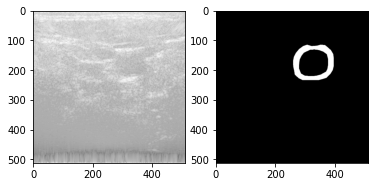

In [81]:
imshow(bmode, mask)

In [34]:
# deconvolution layer definition
class deconvol(nn.Module):
    def __init__(self, out_channels, kernel_size, num_layer, name, channel_change, bias=True):
        super().__init__()
        self.sequence = nn.Sequential()
        # unpooling layer
        unpool_layer = nn.MaxUnpool2d(
                kernel_size=2,
                stride=2,
                padding=0,
                # dilation=1,
                # ceil_mode=False
            )
        self.sequence.add_module('Max Unpooling ' + name, unpool_layer)
        
        # Deconvolution layers, number based on input num_layer
        for i in range(num_layer - 1):
            self.sequence.add_module('Deconv '+ name + str(i),
                                nn.ConvTranspose2d(
                                    in_channels=out_channels,          
                                    out_channels=out_channels,            
                                    kernel_size=kernel_size,
                                    bias=bias
                                )
                               )
        final_out_channels = int(out_channels/2 if channel_change else out_channels)
        self.sequence.add_module('Deconv' + name + str(i),
                            nn.ConvTranspose2d(
                                in_channels=out_channels,    
                                out_channels= final_out_channels,
                                kernel_size=kernel_size,
                                bias=bias
                            )
                           )
    def forward(self, x):
        return self.sequence(x)

In [35]:
# download pretrained vgg16 models
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = models.vgg16(pretrained=True)

In [36]:
# content of pretrained vgg16
model_encode = nn.Sequential(*[model_ft.features])
print(model_encode)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [37]:
# turn off gradient vgg16
for param in model_encode.parameters():
    param.requires_grad = False

In [38]:
# construct main model
class main_model(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_layer, name, bias=True):

        super().__init__()
        # build upon vgg16
        self.sequence = model_encode
        self.sequence.add_module("Flatten", nn.Flatten())
        
        self.sequence.add_module( "Linear1", nn.Linear(in_features=in_channels,  out_features=out_channels, bias=bias) )
        self.sequence.add_module( "Linear2", nn.Linear(in_features=out_channels, out_features=out_channels, bias=bias) )
        self.sequence.add_module( "Linear3", nn.Linear(in_features=out_channels, out_features=in_channels,  bias=bias) )
        
#         sequence.add_module( nn.Linear(in_features=25088, out_features=4096,  bias=True) )
#         sequence.add_module( nn.Linear(in_features=4096,  out_features=4096,  bias=True) )
#         sequence.add_module( nn.Linear(in_features=4096,  out_features=25088, bias=True) )
        
        # deconvolution block
        self.deconv_block = nn.Sequential()
        # deconvol input: out_channels, kernel_size, num_layer, name, channel_change, bias=True
        self.deconv_block.add_module( "Deconv Block 1", deconvol(512, 3, 3, 'deconv1', False, bias) )
        self.deconv_block.add_module( "Deconv Block 2", deconvol(512, 3, 3, 'deconv2', True,  bias) )
        self.deconv_block.add_module( "Deconv Block 3", deconvol(256, 3, 3, 'deconv3', True,  bias) )
        self.deconv_block.add_module( "Deconv Block 4", deconvol(128, 3, 2, 'deconv4', True,  bias) )
        self.deconv_block.add_module( "Deconv Block 5", deconvol( 64, 3, 2, 'deconv5', True,  bias) )
        
        self.deconv_block.add_module( "Conv Transpose", nn.ConvTranspose2d(
                                    in_channels=64,
                                    out_channels=64,
                                    kernel_size=1,
                                    stride=1,
                                    padding=1,
                                    bias=bias
                                )
                               )

    def forward(self, x):
        x = self.sequence(x)
        x = torch.reshape(x, (None, 7, 7, 512))
        return self.deconv_block(x)

In [39]:
print(main_model(in_channels=25088, out_channels=4096, kernel_size=0, num_layer=0, name="training"))

main_model(
  (sequence): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [40]:
# create vgg16 model, return model and optim.sgd of model with learning rate
def get_model(in_channels=25088, out_channels=4096, kernel_size=0, num_layer=0, name="vgg16", learning_rate=0.001):
    model = main_model(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        num_layer=num_layer,
        name=name
    )
    return model, optim.SGD(model.parameters(), lr=learning_rate)

In [41]:
def loss_batch(model, xb, yb, loss_func=F.cross_entropy, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [42]:
def fit(epochs, model, loss_func, train_dl, valid_dl):
    for epoch in range(epochs):
        model.forward()
        loss1 = []
        num = []
        for xb, yb in train_dl:
            losses, nums = loss_batch(model, loss_func, xb, yb)
        loss1.append(losses)
        num.append(nums)
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss, train_loss)

In [43]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
def get_data(x_train, y_train, x_valid, y_valid, bs):
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_ds = TensorDataset(x_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
    return (train_dl, valid_dl)

In [44]:
vgg, optimizer = get_model()

In [45]:
fit(1, vgg, F.cross_entropy, train_loader, test_loader)

TypeError: forward() missing 1 required positional argument: 'x'

In [60]:
def main(args):
    net, optimizer = get_model()
    criterion = create_criterion()
    

    train_loader = torch.utils.data.DataLoader(
                     dataset=train_set,
                     batch_size=args.batch_size,
                     shuffle=True)
    test_loader = torch.utils.data.DataLoader(
                    dataset=test_set,
                    batch_size=args.batch_size,
                    shuffle=False)
    
    # send net to gpu
    net.to(args.device)
    
    if args.load:
        net.load_state_dict(torch.load(os.path.join(args.ckpt_dir, 'net_best.pth')))
        print("========== load checkpoints successfully! ==========")
    
    if args.eval:
        print("========== evaluating... ==========")
        evaluate(net, test_loader, criterion, args)
        print("========== evaluation done! ==========")
        return

    
    # Training loop
    for epoch in range(1, args.epochs + 1):
        # traning function
        train(net, train_loader, criterion, optimizer, epoch, args)
        
        # Evaluation and visualization
        if epoch % args.eval_epoch == 0:
            cur_loss = evaluate_epoch(net, test_loader, criterion, epoch, args)
            # checkpointing
            checkpoint(net, epoch, cur_loss ,args)

    print('Training Done!')

def checkpoint(net, epoch, cur_loss, args):
    print('Saving checkpoints at {} epochs.'.format(epoch))
    suffix_latest = 'latest.pth'
    suffix_best = 'best.pth'

    torch.save(net.state_dict(),
               '{}/net_{}'.format(args.ckpt_dir, suffix_latest))

    if cur_loss < args.best_loss:
        args.best_acc = cur_loss
        torch.save(net.state_dict(),
                       '{}/net_{}'.format(args.ckpt_dir, suffix_best))

In [82]:
def create_criterion():
    return torch.nn.MSELoss()

def evaluate(net, loader, criterion, args):
    net.eval()
    
    Loss = 0
    count = 0
    with torch.no_grad():
        for i, batch in enumerate(loader):

            x, y = batch[0].to(args.device), batch[1].to(args.device)
            y_hat = net.forward(x, args.n_steps_ahead).transpose(1,2) 
            loss = criterion(y_hat, y)
            
            Loss += loss.item()
            count += 1

            final_image = show_video(x, y_hat, y)
            save_img(final_image, args, str(i))
        
        avg_loss = Loss / count
        print('Average MSE loss on test dataset: {:.4f}'.format(avg_loss))
    return avg_loss

def train(net, loader, criterion, optimizer, epoch, args):
    net.train()
    
    for i, batch in enumerate(loader):
        
        x, y = batch[0].to(args.device).float(), batch[1].to(args.device).float()
        
        net.zero_grad()
        x = torch.reshape(x, [16, 3, 512, 512])
        print(x.shape)
        y_hat = net.forward(x).transpose(1,2)

        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        # print training progress every 50 global_step
        if i % 50 == 0:
            print('Epoch:[{}/{}], Step: [{}] '
                  'learning_rate: {}, '
                  'loss: {:.4f}'
                  .format(epoch, args.epochs, i, 
                          args.lr,
                          loss.item()))

def evaluate_epoch(net, loader, criterion, epoch, args):
    net.eval()
    
    Loss = 0
    count = 0
    with torch.no_grad():
        for i, batch in enumerate(loader):

            x, y = batch[0].to(args.device), batch[1].to(args.device)
            y_hat = net.forward(x).transpose(1,2) 
            loss = criterion(y_hat, y)
            
            Loss += loss.item()
            count += 1
        
        final_image = show_video(x, y_hat, y)
        save_img(final_image, args)
        
        avg_loss = Loss / count
        print('Average MSE loss on test dataset: {:.4f}'.format(avg_loss))
    return avg_loss

In [1]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=16, type=int, help='batch size')
    parser.add_argument('--epochs', type=int, default=100, help='number of epochs to train for')
    parser.add_argument('--eval_epoch', type=int, default=1, help='number of epochs to evaluate once')
    parser.add_argument('--n_hidden_dim', type=int, default=64, help='number of hidden dim for ConvLSTM cells')
    parser.add_argument('--n_steps_ahead', type=int, default=10, help='length of predicted sequences')
    parser.add_argument('--ckpt_dir', type=str, default='./ckpt', help='where you save trained model')
    parser.add_argument('--load', type=bool, default=False, help='whether to load the previsous checkpoint')
    parser.add_argument('--eval', type=bool, default=False, help='whether to evaluate the whole test set without training')
    
    args, unknown = parser.parse_known_args()
    
    args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(args.device)


    if not os.path.exists(args.ckpt_dir):
        os.makedirs(args.ckpt_dir)
        
    args.best_loss = float('inf')

    # fix the random seed
    random.seed(1)
    torch.manual_seed(1)
    main(args)

NameError: name 'argparse' is not defined